In [211]:
import os

import tensorflow as tf
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
import scipy

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [212]:
from statsmodels.tsa.stattools import adfuller, kpss,acf,pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [213]:
# plt.style.use('ggplot')

In [214]:
df = pd.read_csv("jena_climate_2009_2016.csv")

In [215]:
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [217]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


In [219]:
df.isnull().sum()

Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

Let's check the `T (degC)` column

In [222]:
temp = df['T (degC)']

In [223]:
temp

0        -8.02
1        -8.41
2        -8.51
3        -8.31
4        -8.27
          ... 
420546   -4.05
420547   -3.35
420548   -3.16
420549   -4.23
420550   -4.82
Name: T (degC), Length: 420551, dtype: float64

<Axes: >

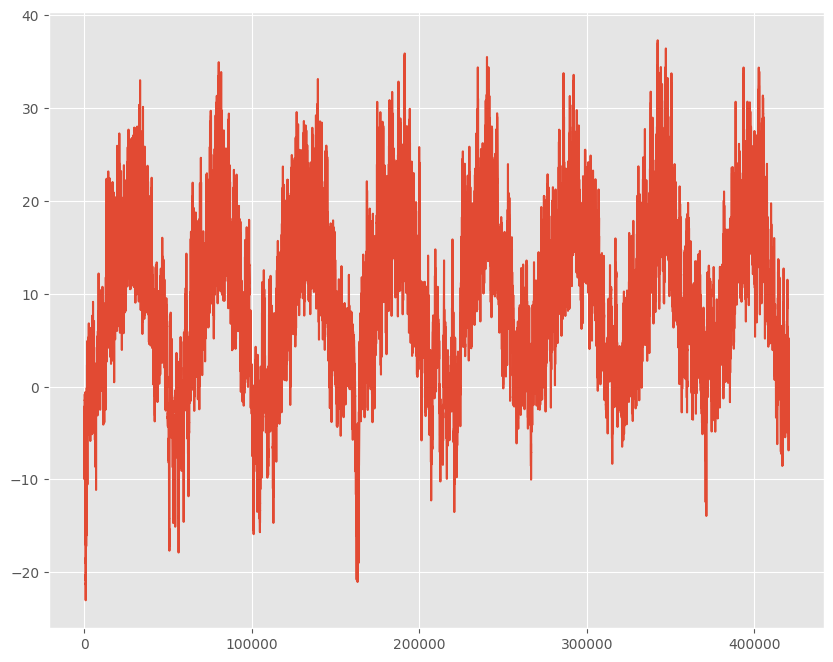

In [224]:
temp = df['T (degC)']
temp.plot(figsize=(10, 8))

The X-Axis is not interpretable, as it is only showing the data points rather than time itself.
We can fix this by creating index out of `Date Time` column

In [225]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

<Axes: xlabel='Date Time'>

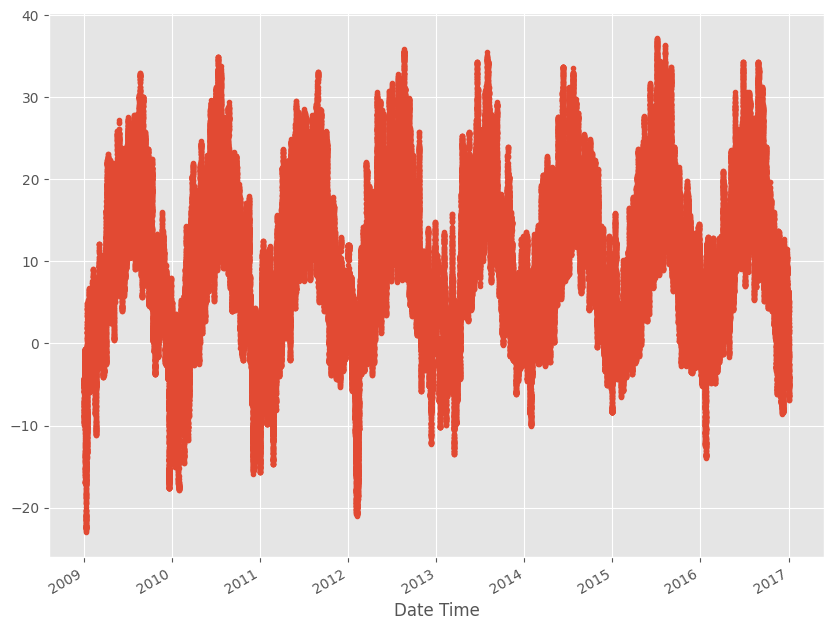

In [226]:
temp_df = df[['T (degC)', 'Date Time']]
temp_df['T (degC)'].plot(style=".", figsize=(10, 8))

In [227]:
temp_df

,T (degC),Date Time
Date Time,,
2009-01-01 00:10:00,-8.02,01.01.2009 00:10:00
2009-01-01 00:20:00,-8.41,01.01.2009 00:20:00
2009-01-01 00:30:00,-8.51,01.01.2009 00:30:00
2009-01-01 00:40:00,-8.31,01.01.2009 00:40:00
2009-01-01 00:50:00,-8.27,01.01.2009 00:50:00
...,...,...
2016-12-31 23:20:00,-4.05,31.12.2016 23:20:00
2016-12-31 23:30:00,-3.35,31.12.2016 23:30:00
2016-12-31 23:40:00,-3.16,31.12.2016 23:40:00


In [229]:
def create_time_features(df:pd.DataFrame):
    df = df.copy()
    df["day"] = df.index.day
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayOfYear"] = df.index.dayofyear
    return df

In [230]:
temp_df_timefeatures = create_time_features(temp_df)

In [231]:
temp_df_timefeatures

,T (degC),Date Time,day,month,year,dayOfYear
Date Time,,,,,,
2009-01-01 00:10:00,-8.02,01.01.2009 00:10:00,1,1,2009,1
2009-01-01 00:20:00,-8.41,01.01.2009 00:20:00,1,1,2009,1
2009-01-01 00:30:00,-8.51,01.01.2009 00:30:00,1,1,2009,1
2009-01-01 00:40:00,-8.31,01.01.2009 00:40:00,1,1,2009,1
2009-01-01 00:50:00,-8.27,01.01.2009 00:50:00,1,1,2009,1
...,...,...,...,...,...,...
2016-12-31 23:20:00,-4.05,31.12.2016 23:20:00,31,12,2016,366
2016-12-31 23:30:00,-3.35,31.12.2016 23:30:00,31,12,2016,366
2016-12-31 23:40:00,-3.16,31.12.2016 23:40:00,31,12,2016,366


In [87]:
temp_df_timefeatures.columns

Index(['T (degC)', 'Date Time', 'day', 'month', 'year', 'dayOfYear'], dtype='object')

## Forecasting using XGBoost Regressor

### Train-test-split

In [232]:
temp_df_train = temp_df_timefeatures.loc[temp_df.index < "01-01-2015"]
temp_df_test = temp_df_timefeatures.loc[temp_df.index >= "01-01-2015"]

In [233]:
# temp_df_train.to_csv("temp_df_train.csv")

In [234]:
# temp_df_test.to_csv("temp_df_test.csv")

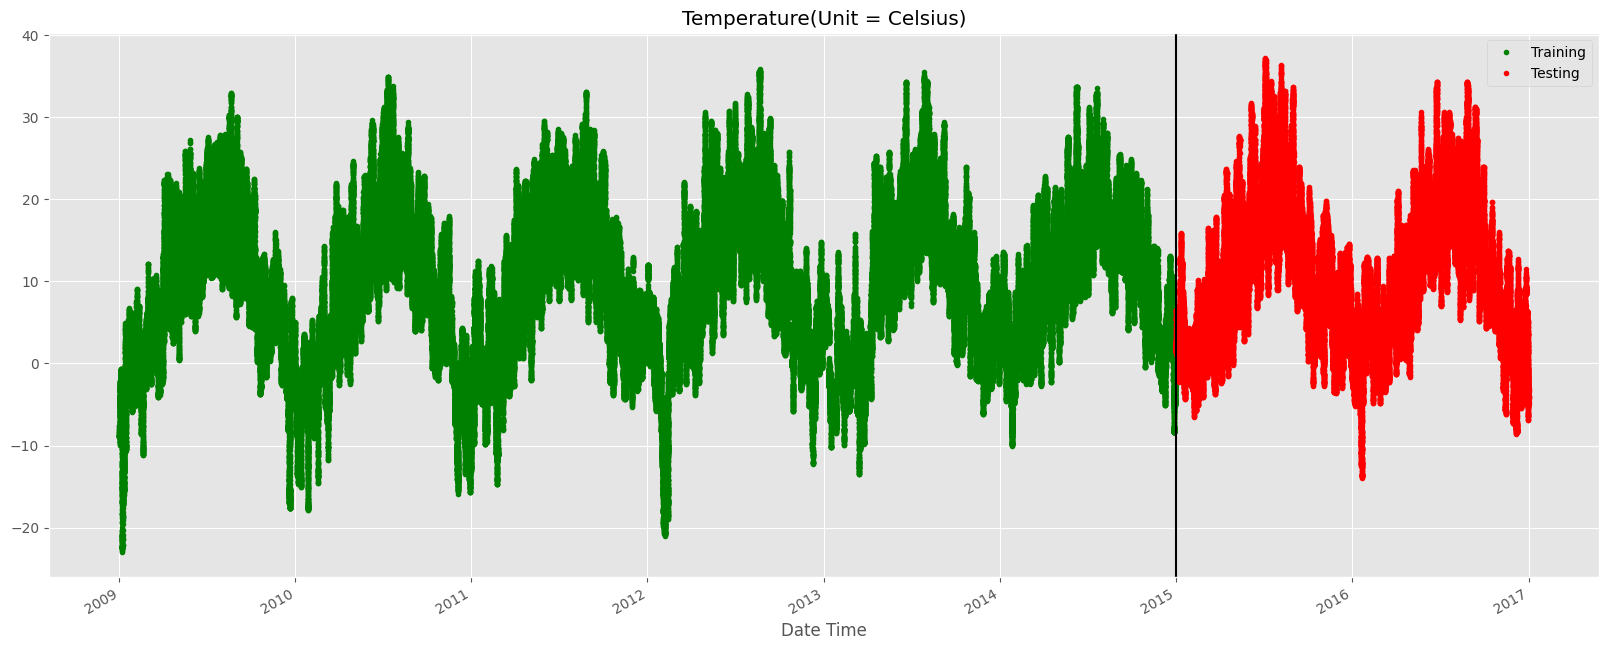

In [235]:
fig, ax = plt.subplots(figsize=(20, 8))

temp_df_train["T (degC)"].plot(style=".", ax=ax, label="Training", color="g", title="Temperature(Unit = Celsius)")

temp_df_test['T (degC)'].plot(style=".", ax=ax, label="Testing", color="r")

ax.axvline("01-01-2015", color="black", ls="-")

ax.legend(["Training", "Testing"])

plt.show()

In [91]:
temp_df_train

,T (degC),Date Time,day,month,year,dayOfYear
Date Time,,,,,,
2009-01-01 00:10:00,-8.02,01.01.2009 00:10:00,1,1,2009,1
2009-01-01 00:20:00,-8.41,01.01.2009 00:20:00,1,1,2009,1
2009-01-01 00:30:00,-8.51,01.01.2009 00:30:00,1,1,2009,1
2009-01-01 00:40:00,-8.31,01.01.2009 00:40:00,1,1,2009,1
2009-01-01 00:50:00,-8.27,01.01.2009 00:50:00,1,1,2009,1
...,...,...,...,...,...,...
2014-12-31 23:10:00,2.08,31.12.2014 23:10:00,31,12,2014,365
2014-12-31 23:20:00,2.09,31.12.2014 23:20:00,31,12,2014,365
2014-12-31 23:30:00,2.17,31.12.2014 23:30:00,31,12,2014,365


In [237]:
FEATURES = ['day', 'month', 'year', 'dayOfYear']

LABEL = ['T (degC)']

Creating `X_train` and `y_train`

In [238]:
X_train = temp_df_train[FEATURES]

y_train = temp_df_train[LABEL]

Creating `X_test` and `y_test`

In [96]:
X_test = temp_df_test[FEATURES]

y_test = temp_df_test[LABEL]

In [239]:
xgb_regressor = xgb.XGBRegressor(n_estimators=1000, 
                                 early_stopping_rounds=50,
                                 learning_rate = 0.01)

In [240]:
xgb_regressor.fit(X_train, 
                  y_train,
                  eval_set = [(X_train, y_train), (X_test, y_test)],
                  verbose=50)

[0]	validation_0-rmse:8.47595	validation_1-rmse:8.04207
[50]	validation_0-rmse:6.26232	validation_1-rmse:6.42363
[100]	validation_0-rmse:5.16810	validation_1-rmse:5.70950
[150]	validation_0-rmse:4.62435	validation_1-rmse:5.41024
[200]	validation_0-rmse:4.35646	validation_1-rmse:5.31690
[250]	validation_0-rmse:4.20764	validation_1-rmse:5.30012
[282]	validation_0-rmse:4.14447	validation_1-rmse:5.30507


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [241]:
feature_importance = pd.DataFrame(data=xgb_regressor.feature_importances_,
                                  index=xgb_regressor.feature_names_in_,
                                  columns=["Importance"])

In [242]:
feature_importance

,Importance
day,0.035169
month,0.029649
year,0.081547
dayOfYear,0.853635


<Axes: title={'center': 'Feature Importance'}>

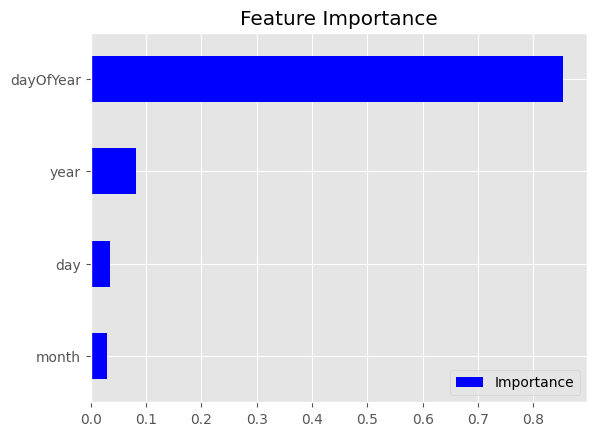

In [243]:
feature_importance.sort_values("Importance").plot(kind="barh", 
                                                  title="Feature Importance",
                                                  color="b")

In [244]:
temp_df_test["xgb_forecasting"] = xgb_regressor.predict(X_test)

In [245]:
temp_df_test

,T (degC),Date Time,day,month,year,dayOfYear,xgb_forecasting
Date Time,,,,,,,
2015-01-01 00:00:00,2.06,01.01.2015 00:00:00,1,1,2015,1,4.555560
2015-01-01 00:10:00,2.15,01.01.2015 00:10:00,1,1,2015,1,4.555560
2015-01-01 00:20:00,2.10,01.01.2015 00:20:00,1,1,2015,1,4.555560
2015-01-01 00:30:00,2.08,01.01.2015 00:30:00,1,1,2015,1,4.555560
2015-01-01 00:40:00,2.07,01.01.2015 00:40:00,1,1,2015,1,4.555560
...,...,...,...,...,...,...,...
2016-12-31 23:20:00,-4.05,31.12.2016 23:20:00,31,12,2016,366,2.291175
2016-12-31 23:30:00,-3.35,31.12.2016 23:30:00,31,12,2016,366,2.291175
2016-12-31 23:40:00,-3.16,31.12.2016 23:40:00,31,12,2016,366,2.291175


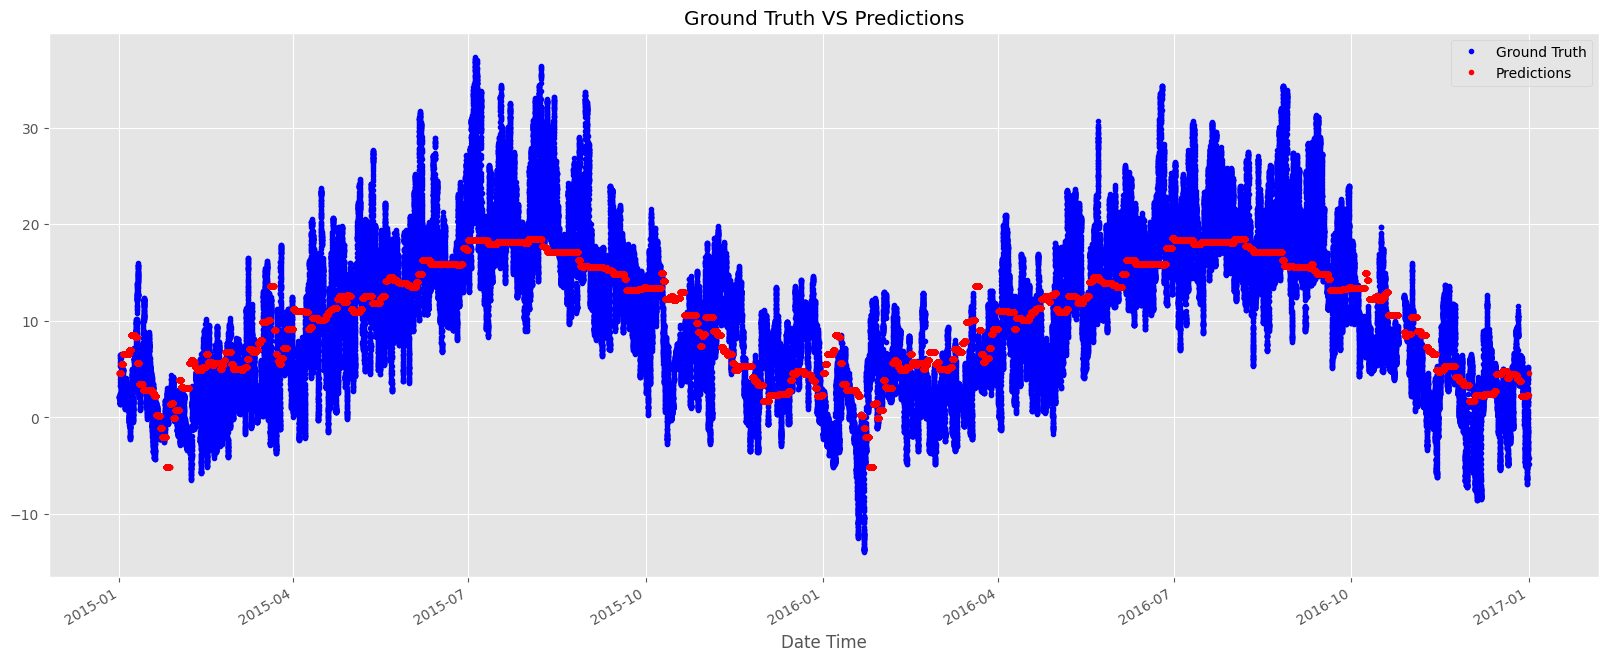

In [246]:
ax = temp_df_test[["T (degC)"]].plot(figsize=(20, 8), style=".", color="b")
temp_df_test["xgb_forecasting"].plot(ax=ax, style=".", color="r")
plt.legend(["Ground Truth", "Predictions"])
plt.title("Ground Truth VS Predictions")
plt.show()

## Forecasting using LSTM

Data preparation for LSTM model

In [247]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [248]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((420546, 5, 1), (420546,))

In [249]:
X_train1, y_train1 = X1[:380000], y1[:380000]
X_val1, y_val1 = X1[380000:400000], y1[380000:400000]
X_test1, y_test1 = X1[400000:], y1[400000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((380000, 5, 1), (380000,), (20000, 5, 1), (20000,), (20546, 5, 1), (20546,))

In [250]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, InputLayer, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model


In [114]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(32))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [251]:
cp1 = ModelCheckpoint('model_2/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [252]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=2, callbacks=[cp1])

Epoch 1/2
11860/11875 [============================>.] - ETA: 0s - loss: 0.0429 - root_mean_squared_error: 0.2071INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


11875/11875 [==============================] - 80s 7ms/step - loss: 0.0429 - root_mean_squared_error: 0.2071 - val_loss: 0.0609 - val_root_mean_squared_error: 0.2468
Epoch 2/2
11872/11875 [============================>.] - ETA: 0s - loss: 0.0428 - root_mean_squared_error: 0.2069INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


11875/11875 [==============================] - 80s 7ms/step - loss: 0.0428 - root_mean_squared_error: 0.2069 - val_loss: 0.0592 - val_root_mean_squared_error: 0.2433


In [116]:
# model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
11874/11875 [============================>.] - ETA: 0s - loss: 6.3413 - root_mean_squared_error: 2.5182INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


11875/11875 [==============================] - 30s 2ms/step - loss: 6.3408 - root_mean_squared_error: 2.5181 - val_loss: 0.0648 - val_root_mean_squared_error: 0.2545
Epoch 2/10
11862/11875 [============================>.] - ETA: 0s - loss: 0.0468 - root_mean_squared_error: 0.2162INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


11875/11875 [==============================] - 30s 3ms/step - loss: 0.0468 - root_mean_squared_error: 0.2162 - val_loss: 0.0621 - val_root_mean_squared_error: 0.2493
Epoch 3/10
11864/11875 [============================>.] - ETA: 0s - loss: 0.0443 - root_mean_squared_error: 0.2105INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


11875/11875 [==============================] - 30s 3ms/step - loss: 0.0443 - root_mean_squared_error: 0.2105 - val_loss: 0.0596 - val_root_mean_squared_error: 0.2442
Epoch 4/10
11875/11875 [==============================] - 30s 2ms/step - loss: 0.0435 - root_mean_squared_error: 0.2086 - val_loss: 0.0606 - val_root_mean_squared_error: 0.2462
Epoch 5/10
11875/11875 [==============================] - 31s 3ms/step - loss: 0.0433 - root_mean_squared_error: 0.2081 - val_loss: 0.0614 - val_root_mean_squared_error: 0.2477
Epoch 6/10
11858/11875 [============================>.] - ETA: 0s - loss: 0.0431 - root_mean_squared_error: 0.2076INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


11875/11875 [==============================] - 30s 3ms/step - loss: 0.0431 - root_mean_squared_error: 0.2075 - val_loss: 0.0595 - val_root_mean_squared_error: 0.2438
Epoch 7/10
11866/11875 [============================>.] - ETA: 0s - loss: 0.0430 - root_mean_squared_error: 0.2073INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


11875/11875 [==============================] - 29s 2ms/step - loss: 0.0430 - root_mean_squared_error: 0.2073 - val_loss: 0.0594 - val_root_mean_squared_error: 0.2437
Epoch 8/10
11865/11875 [============================>.] - ETA: 0s - loss: 0.0430 - root_mean_squared_error: 0.2074INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


11875/11875 [==============================] - 29s 2ms/step - loss: 0.0430 - root_mean_squared_error: 0.2074 - val_loss: 0.0591 - val_root_mean_squared_error: 0.2432
Epoch 9/10
11875/11875 [==============================] - 27s 2ms/step - loss: 0.0428 - root_mean_squared_error: 0.2070 - val_loss: 0.0594 - val_root_mean_squared_error: 0.2437
Epoch 10/10
11875/11875 [==============================] - 27s 2ms/step - loss: 0.0429 - root_mean_squared_error: 0.2070 - val_loss: 0.0609 - val_root_mean_squared_error: 0.2467


In [254]:
model1 = load_model('model_2/')

### Training Results

In [255]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})

11875/11875 [==============================] - 41s 3ms/step


Text(0, 0.5, 'Temperature in celsius')

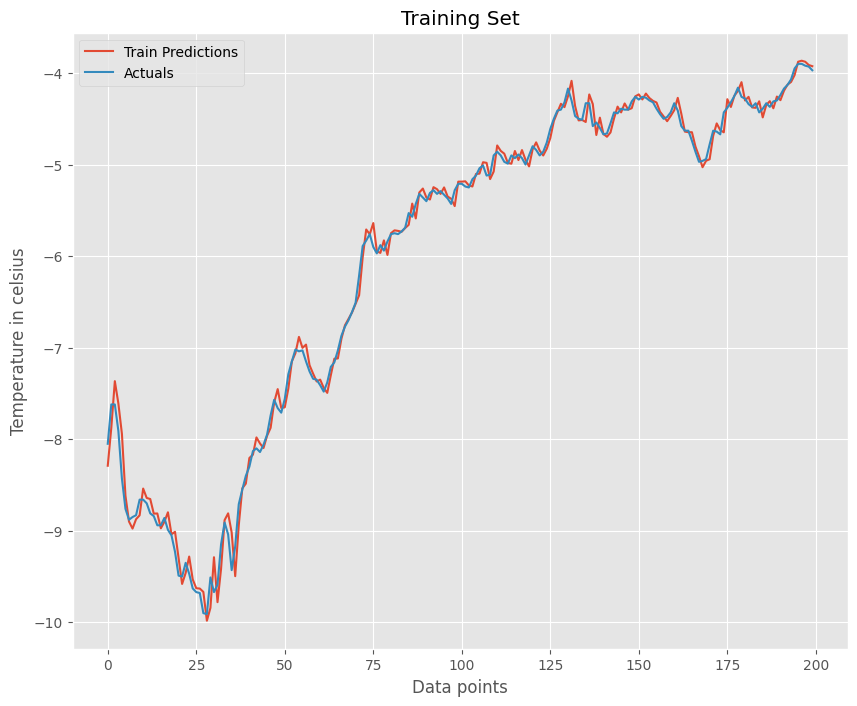

In [256]:
train_results['Train Predictions'][0:200].plot.line(figsize=(10, 8), legend=True)
train_results['Actuals'][0:200].plot.line(legend=True)
plt.title("Training Set")
plt.xlabel("Data points")
plt.ylabel("Temperature in celsius")

In [257]:
mse = mean_squared_error(train_results["Train Predictions"], train_results["Actuals"])
print(f"MSE: {mse:.4f}; RMSE: {np.sqrt(mse):.4f}")

MSE: 0.0423; RMSE: 0.2057


### Validation Result

In [258]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

  1/625 [..............................] - ETA: 24s

625/625 [==============================] - 2s 3ms/step


,Val Predictions,Actuals
0,4.957889,4.98
1,5.126061,5.14
2,5.291365,5.25
3,5.368760,5.22
4,5.240315,5.28
...,...,...
19995,13.970564,13.93
19996,13.845635,14.01
19997,14.029859,14.06
19998,14.031796,14.15


Text(0, 0.5, 'Temperature in celsius')

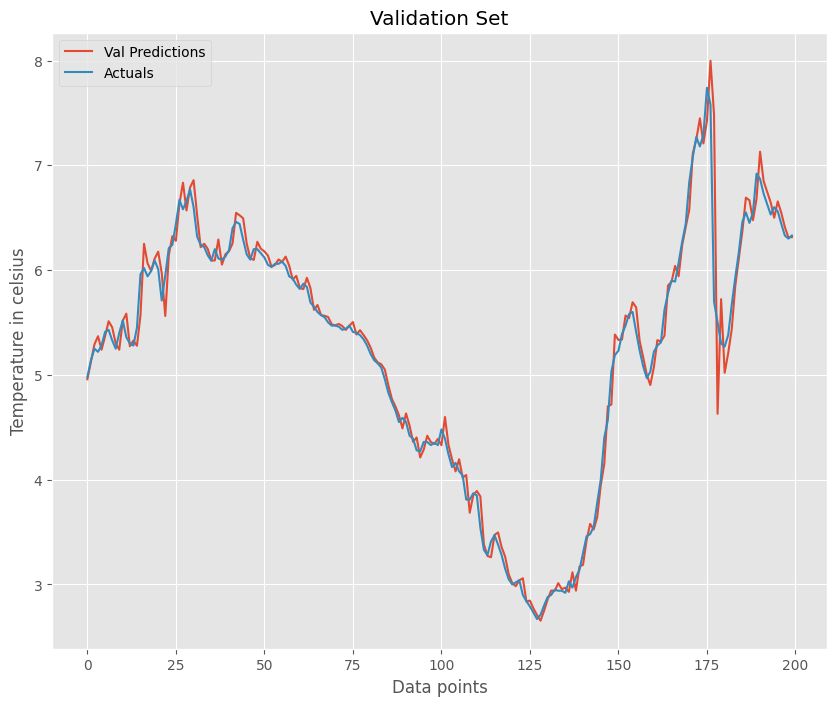

In [259]:
val_results['Val Predictions'][0:200].plot.line(figsize=(10, 8), legend=True)
val_results['Actuals'][0:200].plot.line(legend=True)
plt.title("Validation Set")
plt.xlabel("Data points")
plt.ylabel("Temperature in celsius")

In [260]:
mse = mean_squared_error(val_results["Val Predictions"], val_results["Actuals"])
print(f"MSE: {mse:.4f}; RMSE: {np.sqrt(mse):.4f}")

MSE: 0.0592; RMSE: 0.2433


### Testing Result

In [261]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

643/643 [==============================] - 3s 3ms/step


,Test Predictions,Actuals
0,14.759934,14.80
1,14.932071,15.08
2,15.277277,15.67
3,16.033968,16.41
4,16.823940,17.13
...,...,...
20541,-3.991561,-4.05
20542,-4.031504,-3.35
20543,-2.987349,-3.16
20544,-3.128951,-4.23


Text(0, 0.5, 'Temperature in celsius')

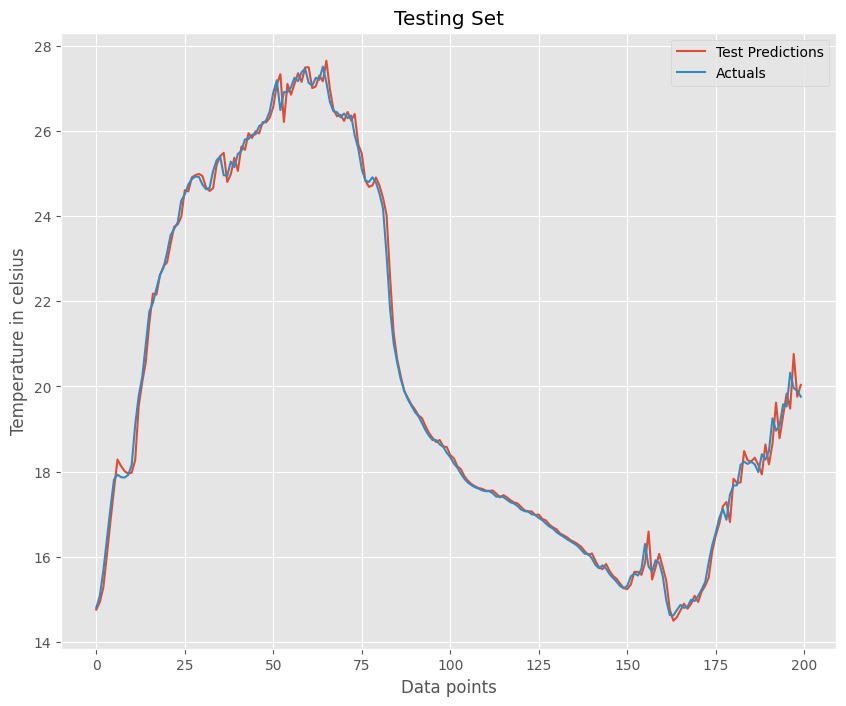

In [262]:
test_results['Test Predictions'][0:200].plot.line(legend=True, figsize=(10, 8))
test_results['Actuals'][0:200].plot.line(legend=True)
plt.title("Testing Set")
plt.xlabel("Data points")
plt.ylabel("Temperature in celsius")

In [263]:
mse = mean_squared_error(test_results["Test Predictions"], test_results["Actuals"])
print(f"MSE: {mse:.4f}; RMSE: {np.sqrt(mse):.4f}")

MSE: 0.0342; RMSE: 0.1848


## ARIMA Model

In [141]:
temp_df_timefeatures

,T (degC),Date Time,day,month,year,dayOfYear
Date Time,,,,,,
2009-01-01 00:10:00,-8.02,01.01.2009 00:10:00,1,1,2009,1
2009-01-01 00:20:00,-8.41,01.01.2009 00:20:00,1,1,2009,1
2009-01-01 00:30:00,-8.51,01.01.2009 00:30:00,1,1,2009,1
2009-01-01 00:40:00,-8.31,01.01.2009 00:40:00,1,1,2009,1
2009-01-01 00:50:00,-8.27,01.01.2009 00:50:00,1,1,2009,1
...,...,...,...,...,...,...
2016-12-31 23:20:00,-4.05,31.12.2016 23:20:00,31,12,2016,366
2016-12-31 23:30:00,-3.35,31.12.2016 23:30:00,31,12,2016,366
2016-12-31 23:40:00,-3.16,31.12.2016 23:40:00,31,12,2016,366


In [147]:
df_timefeatures = create_time_features(df)

In [148]:
df_timefeatures

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),day,month,year,dayOfYear
Date Time,,,,,,,,,,,,,,,,,,,
2009-01-01 00:10:00,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3,1,1,2009,1
2009-01-01 00:20:00,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1,1,1,2009,1
2009-01-01 00:30:00,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6,1,1,2009,1
2009-01-01 00:40:00,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0,1,1,2009,1
2009-01-01 00:50:00,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3,1,1,2009,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:20:00,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0,31,12,2016,366
2016-12-31 23:30:00,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3,31,12,2016,366
2016-12-31 23:40:00,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2,31,12,2016,366


## Check Stationarity of the dataset

`Dickey-Fuller test: `The Dickey-Fuller test is a statistical test used to determine whether a time series data set is stationary. Stationarity is an important concept in time series analysis, and it implies that the statistical properties of a time series, such as mean and variance, do not change over time.

The null hypothesis of the Dickey-Fuller test is that the time series data is non-stationary. A low p-value (typically less than a chosen significance level, e.g., 0.05) leads to the rejection of the null hypothesis, suggesting that the data is stationary.

In [153]:
test_result=adfuller(df_timefeatures["T (degC)"])

In [154]:
test_result

(-9.396414078898719,
 6.356659066257805e-16,
 97,
 420453,
 {'1%': -3.430365553081852,
  '5%': -2.8615468742762458,
  '10%': -2.566773658926636},
 -157669.90750741703)

In [156]:
def adfuller_test(result):
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [157]:
adfuller_test(test_result)

ADF Test Statistic : -9.396414078898719
p-value : 6.356659066257805e-16
#Lags Used : 97
Number of Observations Used : 420453
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [159]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [160]:
kpss_test(df_timefeatures["T (degC)"])

Results of KPSS Test:
Test Statistic             2.053947
p-value                    0.010000
#Lags Used               362.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


C:\Users\Asus\AppData\Local\Temp\ipykernel_25208\3002020788.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")


Test Statistic is higher than any of critical value and p-value < 0.5 === > This Time Series is non- stationary.

Because ADF concludes stationary, and KPSS method concludes non-stationary, thus, this series is difference stationary.

In [166]:
temp_df = df_timefeatures["T (degC)"]

In [171]:
len(temp_df)

420551

In [177]:
temp_df_1D = temp_df[143::144]
temp_df_1D

Date Time
2009-01-02 00:00:00    -4.54
2009-01-03 00:00:00    -4.71
2009-01-04 00:00:00    -1.90
2009-01-05 00:00:00    -1.47
2009-01-06 00:00:00   -12.63
                       ...  
2016-12-27 12:10:00     5.80
2016-12-28 12:10:00     6.03
2016-12-29 12:10:00     3.45
2016-12-30 12:10:00    -0.92
2016-12-31 12:10:00    -0.71
Name: T (degC), Length: 2920, dtype: float64

### Autocorrelation

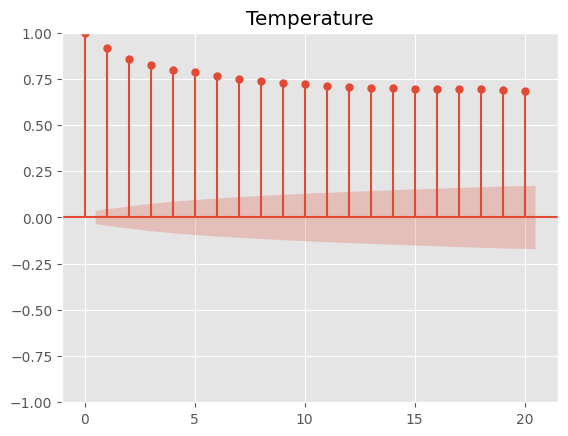

In [181]:
sm.graphics.tsa.plot_acf(temp_df_1D,lags = 20, title = 'Temperature')
plt.show()

### partial Autocorrleation

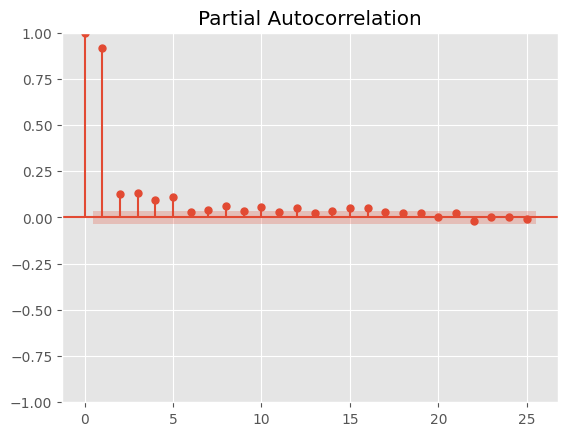

In [182]:
sm.graphics.tsa.plot_pacf(temp_df_1D,lags = 25)
plt.show()

Additive Time Series Secomposition

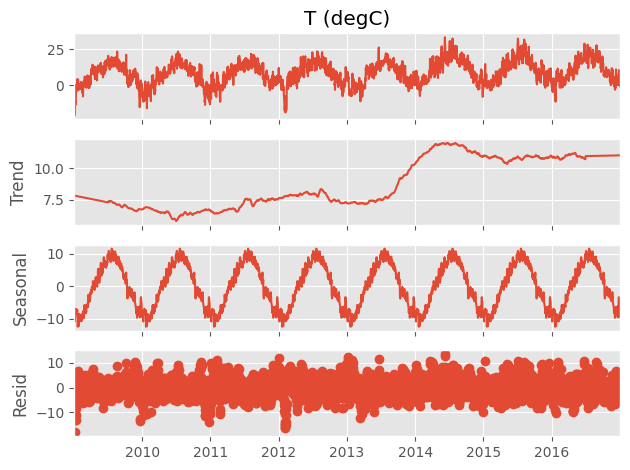

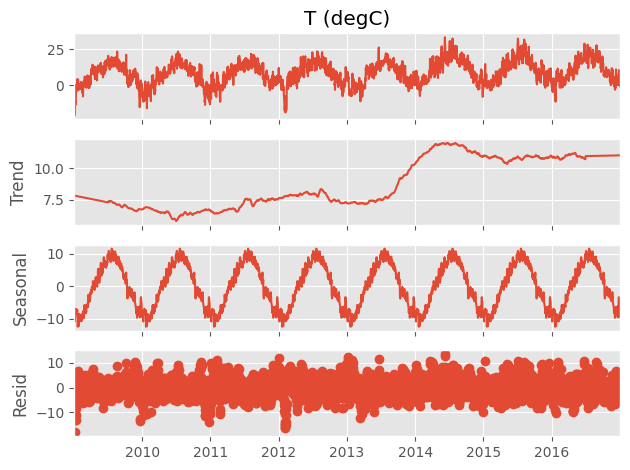

In [183]:
result = seasonal_decompose(temp_df_1D, period=365, model='additive', extrapolate_trend='freq')
result.plot()

In [185]:
from pylab import rcParams
import statsmodels.api as sm

import pmdarima as pm

In [193]:
model = pm.auto_arima(temp_df_1D, start_p=1, start_q=1,
                      test='adf',                      # use adftest to find optimal 'd'
                      max_p=10, max_q=10,              # maximum p and q
                      m=1,                             # frequency of series 1 for annual (non-seasonal) data
                      d=None,                          # let model determine 'd'
                      seasonal=True,                   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=15041.335, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=20453.548, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=15108.594, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=17993.431, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=22716.467, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=14894.958, Time=0.86 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=15062.571, Time=0.21 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=14896.381, Time=1.23 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=14896.347, Time=1.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=14960.834, Time=0.41 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=15011.667, Time=0.32 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=14896.481, Time=1.79 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=14898.528, Time=0.44 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 6.999 seconds
         

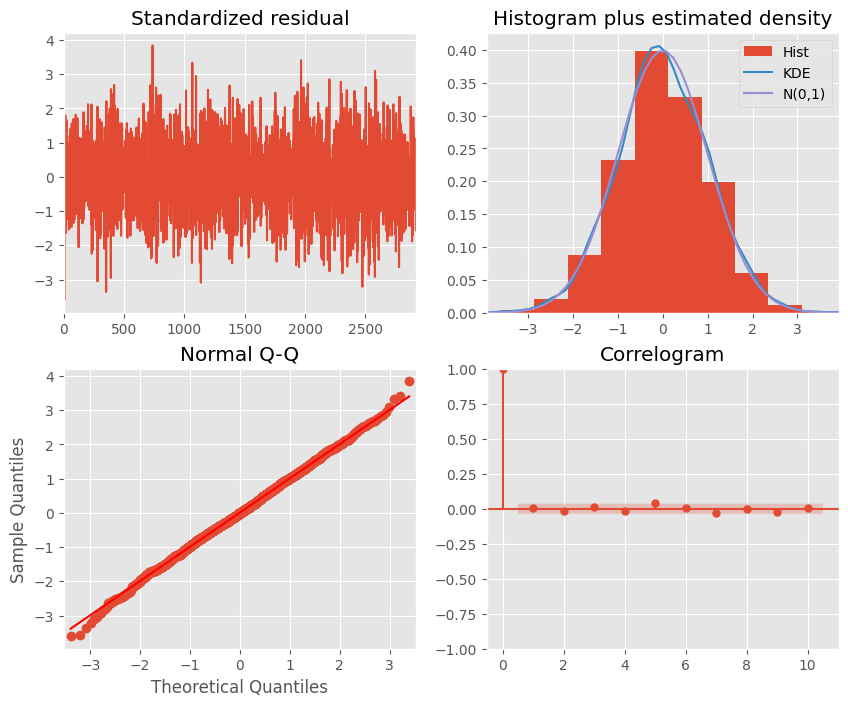

In [194]:
model.plot_diagnostics(figsize=(10,8))
plt.show()

Interpret the plot diagnostics:

1. First plot shows residual errors seem to fluctuate around a mean of zero and have a uniform variance.
2. The density plot suggests normal distribution with mean zero.
QQ Plot shows distribution fall perfectly
3. The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model  
`Overall, it seems to be a good fit.`

In [196]:
model = sm.tsa.arima.ARIMA(temp_df_1D, order=(3,0,1))  
result = model.fit()  
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:               T (degC)   No. Observations:                 2920
Model:                 ARIMA(3, 0, 1)   Log Likelihood               -7442.191
Date:                Mon, 08 Jan 2024   AIC                          14896.381
Time:                        03:26:00   BIC                          14932.257
Sample:                             0   HQIC                         14909.303
                               - 2920                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8888      2.013      3.919      0.000       3.944      11.834
ar.L1          1.6185      0.024     67.027      0.000       1.571       1.666
ar.L2         -0.6370      0.031    -20.841      0.0